In [1]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import timm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import create_RDM, get_device, decode_matlab_strings, TimeSeries, RSA, dRSA
device = get_device()

17:32:11 - device being used: mps


In [2]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    model_name: str = 'vit_l_16'
    img_size: int = 384
cfg = Cfg()

TypeError successfully caught
17:32:11 - There are nans in corr_mat


/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


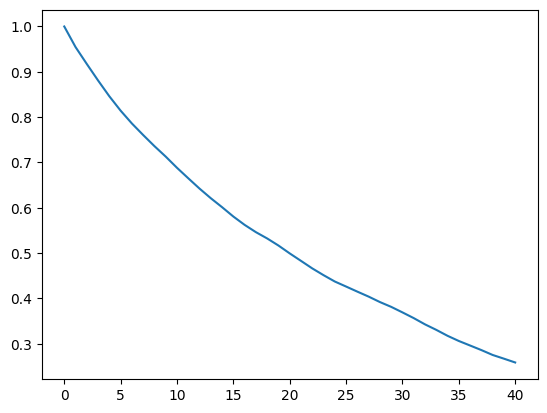

In [3]:
from general_utils.utils import multivariate_ou
ou = multivariate_ou(10, 50, .1, 3).T
try:
    a = TimeSeries(np.split(ou, ou.shape, axis=1), 10)
    au, lp= a.autocorr(max_lag=40)
except TypeError:
    print("TypeError successfully caught")
    a = TimeSeries(ou, 10)
    au, lp= a.autocorr(max_lag=40)


plt.plot(lp)

In [4]:
rasters_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_natraster{cfg.date}.mat"
with h5py.File(rasters_path, "r") as f:
    rasters = f["natraster"][:]      
rasters = rasters.astype(np.float32)
rasters = rasters.transpose(2, 1, 0)
print(rasters.shape) # channels, time, trials

(383, 400, 4377)


In [5]:
ts = TimeSeries(rasters[:20, :, :30], 1000)


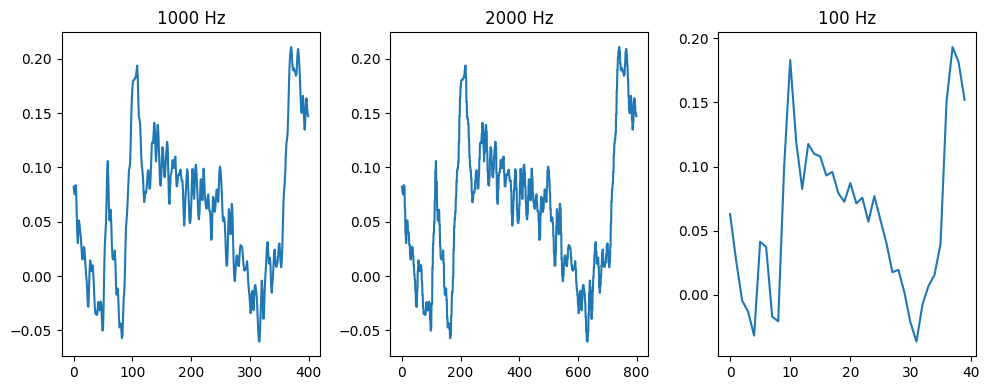

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ts = TimeSeries(rasters[:20, :, :30], 1000)
ax[0].plot(ts.overall_avg())
ax[0].set_title(f"{ts.fs} Hz")
ts.resample(2000)
ax[1].plot(ts.overall_avg())
ax[1].set_title(f"{ts.fs} Hz")
ts.resample(100)
ax[2].plot(ts.overall_avg())
ax[2].set_title(f"{ts.fs} Hz")

plt.tight_layout()

In [8]:

l = "blocks.0.mlp.fc2"
feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]

In [10]:
rsa_obj = RSA('cosine')
rsa_obj.compute_both_RDMs(rasters[:, 100, :], feats.T)
print(rsa_obj.compute_RSA())

0.13007924932250622


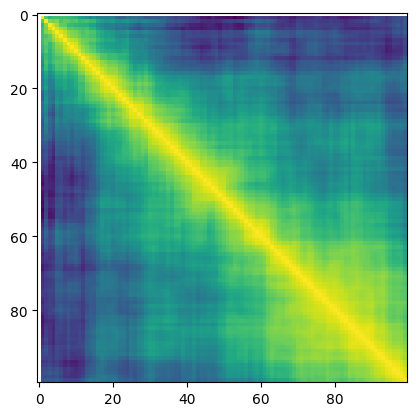

In [7]:
drsa_obj = dRSA('cosine')
a = TimeSeries(ou, 10)
drsa_obj.set_RDM_timeseries(a, "signal")
drsa_obj.set_RDM_timeseries(a, "model")
plt.imshow(drsa_obj.compute_dRSA())

In [11]:
drsa_obj = dRSA(signal_RDM_metric="cosine")

In [16]:
a = TimeSeries(rasters[:20, :, :], 1000)
a.resample(200)

In [17]:
drsa_obj.compute_RDM_timeseries(a, "signal") 

finished


In [18]:

RDM_mod = create_RDM(feats.T[:, :], metric="cosine")
similarity = []

RDMs_list = drsa_obj.get_RDM_timeseries("signal")
for i_time in range(len(RDMs_list)):
    #RDM_neu = squareform(subsample_RDM(squareform(RDMs_list[i_time]), randidx))
    RDM_neu = np.ascontiguousarray(RDMs_list[i_time])
    similarity.append(np.corrcoef(RDM_neu, RDM_mod)[0, 1])

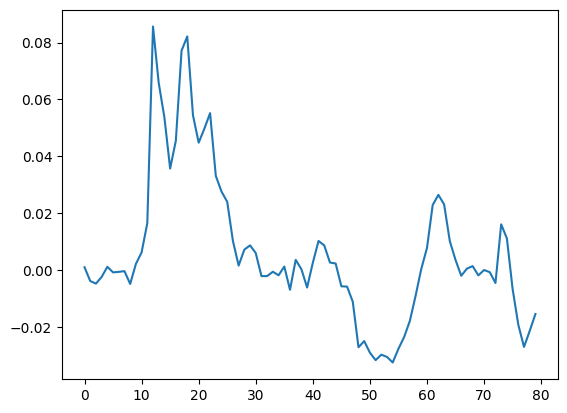

In [19]:
plt.plot(similarity)